# ML Modeling with embedded data
- updated 0908
- data
>4th_FE_ver4_before
>4th_FE_ver4_labelE

1. mape cv -> 지수함수 매핑  
2. basic ml model 성능 기록  
3. data sparse 잡아보기  
4. label data 로 catboost

## y_predict 값들 피클로 저장해놓기

In [ ]:
cd /content/drive/My Drive/빅콘

/content/drive/My Drive/빅콘


In [ ]:
!apt-get update --qq
!apt-get install fonts-nanum* -qq

E: Command line option --qq is not understood in combination with the other options
Selecting previously unselected package fonts-nanum.
(Reading database ... 144579 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig 

In [ ]:
# 한글 폰트
import matplotlib.font_manager as fm
fm._rebuild()

In [ ]:
# ready
import os
import sys
import joblib
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd 
import numpy as np
import random
import math

from IPython.display import display
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.max_info_columns', 500)

import imp
import datetime
from tqdm import tqdm

In [ ]:
# vusualize
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

## Load Data
4th data 2가지 사용  
data['X'] / data['y']

In [ ]:
# load data
## ver4
data_v4 = joblib.load(os.path.join('data', '4th_FE_ver4_before.pk'))
locals().update(data_v4)

## ver4 with label
data_v4_label = joblib.load(os.path.join('data', '4th_FE_ver4_labelE.pk'))
locals().update(data_v4_label)

In [ ]:
X = data_v4['X'] ; y = data_v4['y']
data_v4['X'].shape, data_v4['y'].shape

((35379, 400), (35379,))

In [ ]:
X.isnull().sum()

노출(분)                                                     0
상품군                                                       0
판매단가                                                      0
결제방법                                                      0
방송시간차                                                     0
상품방송횟수                                                    0
브랜드방송횟수                                                4298
조기매진                                                      0
isHoliday                                                 0
방송월                                                       0
방송일                                                       0
방송시간(시간)                                                  0
방송시간(분)                                                   0
평일여부                                                      0
방송시간대                                                     0
계절                                                        0
분기                                      

In [ ]:
# fillna X
X_full = X.copy().fillna(0)
X_full.isnull().sum()

노출(분)                                                 0
상품군                                                   0
판매단가                                                  0
결제방법                                                  0
방송시간차                                                 0
상품방송횟수                                                0
브랜드방송횟수                                               0
조기매진                                                  0
isHoliday                                             0
방송월                                                   0
방송일                                                   0
방송시간(시간)                                              0
방송시간(분)                                               0
평일여부                                                  0
방송시간대                                                 0
계절                                                    0
분기                                                    0
성별                                              

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


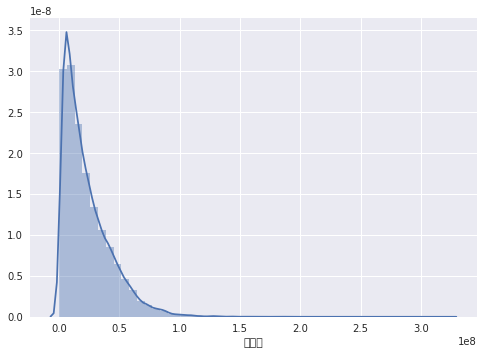

In [ ]:
# target
sns.distplot(y)

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


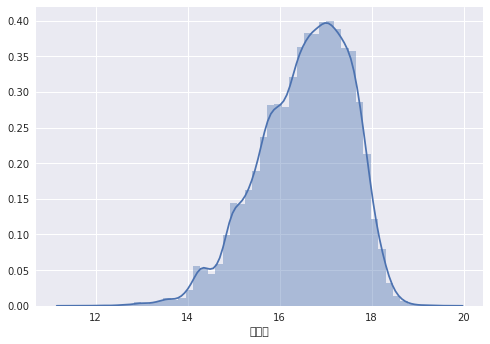

In [ ]:
# log scaling
log_y = np.log(y)
sns.distplot(log_y)

## Modeling

In [ ]:
# ready
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
import random

### 1. 평가기준 CV

In [ ]:
# mape
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# mape with exp
def MAPE_exp(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((np.exp(y_true) - np.exp(y_pred)) / np.exp(y_true))) * 100

In [ ]:
# X, y, n_folds 설정해야함

def mape_cv(model,X,y,n_folds):
  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
  mae = np.abs(-cross_val_score(model, X.values, y, scoring='neg_mean_absolute_error', cv=kf))
  return (mae*(100/sum(y)))

In [ ]:
# MAPE_exp_cv 구현
def MAPE_exp_cv(model,X,y,cv_splits):        
    # setting
    mape = []

    # for 문 돌리기
    cv=KFold(n_splits=cv_splits,random_state=42,shuffle=True)
    for t,v in cv.split(X):
        X_train=X.iloc[t]       # 훈련용
        X_val=X.iloc[v]         # 검증용 분리.
        y_train=y.iloc[t]
        y_val=y.iloc[v]

        # model
        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)
        # mape
        mape.append(MAPE_exp(y_val, y_pred))
    return mape, np.mean(mape)

In [ ]:
# MAPE_exp_cv 구현
def MAPE_exp_cv12(model,X,y,cv_splits):        
    # setting
    mape = []

    # for 문 돌리기
    cv=KFold(n_splits=cv_splits,shuffle=False)
    for t,v in cv.split(X):
        X_train=X.iloc[t]       # 훈련용
        X_val=X.iloc[v]         # 검증용 분리.
        y_train=y.iloc[t]
        y_val=y.iloc[v]

        # model
        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)
        # mape
        mape.append(MAPE_exp(y_val, y_pred))
    return mape, np.mean(mape)

In [ ]:
# TimeSeries Split
# ref https://davinci-ai.tistory.com/18



### 2. Base Modeling with CV MAPE score

|<center>Model</center>|<center>MAPE with cv=5, random</center>| <center>MAPE cv=12</center>|
|:--------|:--------|:--------|
| Linear Regression | 77.18884111031484 |inf|
| Decision Tree | 58.95704205816164 |72.98603429736717|
| KNN | 72.01358615145308 |103.81538728978641|
| Random Forest |39.570740179707656|51.27432189517767|
| GBM | 38.52067143610981 |56.11919654390932|
| LGBM | 43.184383618242705 |45.763609593574614|


* Linear Regression

In [ ]:
# dummy data
X_dum = pd.get_dummies(X_full)
X_dum.shape

(35379, 450)

In [ ]:
# target : y
lr = LinearRegression()
print(mape_cv(lr, X_dum, y, 5))
print('mape : ', np.mean(mape_cv(lr, X_dum, y, 5)))

# target : log_y
print(mape_cv(lr, X_dum, log_y, 5))
print('mape : ', np.mean(mape_cv(lr, X_dum, log_y, 5)))

[6.93746687e+07 7.77440609e+01 2.39210508e+01 1.51269251e+00
 1.24262036e+07]
mape :  16360195.092236087


In [ ]:
MAPE_exp_cv(lr,X_dum,log_y,5)

([79.72773692260667,
  77.41179216851596,
  75.58539229180833,
  77.25411920679934,
  75.96516496184394],
 77.18884111031484)

* Decision Tree

In [ ]:
dt = DecisionTreeRegressor(max_depth=10)
MAPE_exp_cv(dt,X_dum,log_y,5)

([62.03210438819128,
  59.17975225016126,
  57.88865944301526,
  57.43250765376276,
  58.252186555677646],
 58.95704205816164)

* KNN (비지도라 의미있을 듯)

In [ ]:
knn = KNeighborsRegressor(n_neighbors = 10)
MAPE_exp_cv(knn,X_dum,log_y,5)

([73.97190061531252,
  71.19050900014521,
  72.13011711075944,
  71.13397746491975,
  71.64142656612847],
 72.01358615145308)

* Random Forest (배깅)

In [ ]:
rf = RandomForestRegressor()
MAPE_exp_cv(rf,X_dum,log_y,5)

([41.580714989792845,
  38.40745368987796,
  38.83926433371026,
  39.81774737614473,
  39.208520509012494],
 39.570740179707656)

* GBM

In [ ]:
# gbm 은 왠지 모르게 nan이 나옵니다^^
gbm = GradientBoostingRegressor(learning_rate = 0.5, max_depth=5, loss='huber')
MAPE_exp_cv(gbm,X_dum,log_y,5)

([40.74494909130056,
  37.57331826065219,
  38.55673295947469,
  38.465668094256905,
  37.262688774864685],
 38.52067143610981)

* lgbm

In [ ]:
import lightgbm as lgb

In [ ]:
# lgbm setting
X = X_dum
y = log_y
mape = []

# for 문 돌리기
cv=KFold(n_splits=5,random_state=42,shuffle=True)
for t,v in cv.split(X):
    X_train=X.iloc[t]       # 훈련용
    X_val=X.iloc[v]         # 검증용 분리.
    y_train=y.iloc[t]
    y_val=y.iloc[v]

    train_ds = lgb.Dataset(X_train, label=y_train)
    test_ds = lgb.Dataset(X_val, label=y_val)

    params={
        'learning_rate':0.01,
        'max_depth':16,
        'boosting':'dart',
        'objective':'regression',
        'metric':'mape',
        'is_training_metric':True,
        'num_leaves':144,
        'feature_fraction':0.9,
        'bagging_fraction':0.7,
        'bagging_freq':5,
        'seed':1004
    }

    lgbm_model = lgb.train(params,train_ds,5000,test_ds,verbose_eval=1000)
    y_pred = lgbm_model.predict(X_val)
    # mape
    mape.append(MAPE_exp(y_val, y_pred))
print(mape, np.mean(mape))

[1000]	valid_0's mape: 0.154335
[2000]	valid_0's mape: 0.0609867
[3000]	valid_0's mape: 0.0515959
[4000]	valid_0's mape: 0.0378403
[5000]	valid_0's mape: 0.0340648
[1000]	valid_0's mape: 0.154861
[2000]	valid_0's mape: 0.061401
[3000]	valid_0's mape: 0.0519943
[4000]	valid_0's mape: 0.0379888
[5000]	valid_0's mape: 0.0341575
[1000]	valid_0's mape: 0.154954
[2000]	valid_0's mape: 0.061341
[3000]	valid_0's mape: 0.0518992
[4000]	valid_0's mape: 0.0379711
[5000]	valid_0's mape: 0.0341882
[1000]	valid_0's mape: 0.154738
[2000]	valid_0's mape: 0.0615987
[3000]	valid_0's mape: 0.05215
[4000]	valid_0's mape: 0.0381605
[5000]	valid_0's mape: 0.0343399
[1000]	valid_0's mape: 0.155495
[2000]	valid_0's mape: 0.0620962
[3000]	valid_0's mape: 0.0525899
[4000]	valid_0's mape: 0.0385482
[5000]	valid_0's mape: 0.0346475
[43.857755223526226, 43.026676153686076, 42.62293544166901, 43.19261464582921, 43.22193662650301] 43.184383618242705


* ML with cv=12 score


In [ ]:
# model defalult
lr = LinearRegression()
dt = DecisionTreeRegressor(max_depth=10)
knn = KNeighborsRegressor(n_neighbors = 10)
rf = RandomForestRegressor()
gbm = GradientBoostingRegressor(learning_rate = 0.5, max_depth=5, loss='huber')

In [ ]:
# lr
print('lr : \n',MAPE_exp_cv12(lr,X_dum,log_y,12))
# dt
print('dt : \n',MAPE_exp_cv12(dt,X_dum,log_y,12))
# knn
print('knn : \n',MAPE_exp_cv12(knn,X_dum,log_y,12))
# rf
print('rf : \n',MAPE_exp_cv12(rf,X_dum,log_y,12))
# gbm
print('gbm : \n',MAPE_exp_cv12(gbm,X_dum,log_y,12))

lr : 
 ([inf, 68.06831563678287, 77.53920989647305, 63.13316327411515, 85.33097728742686, 84.5177573404261, 70.89133979997408, 89.46673697743961, 73.75438738044566, 84.2380331738236, 78.54735262130598, 100.88937257975748], inf)
dt : 
 ([73.91258905947592, 68.6497379977323, 82.51389988624483, 63.76991838937275, 67.90046048275597, 65.59491808083557, 64.93156408172108, 71.3803945580917, 69.34612146944112, 70.16534793019272, 71.92159960801177, 105.74586002453029], 72.98603429736717)
knn : 
 ([87.4005119377393, 105.44631009305938, 124.02735930299515, 92.70060264231195, 108.22750364827336, 94.93305177698726, 109.57525401790309, 103.95158064071022, 102.03523319378918, 113.14867500775172, 101.83465308451368, 102.5039121314025], 103.81538728978641)
rf : 
 ([51.44247076259748, 48.2901224000651, 53.8644308817864, 47.16749968966547, 50.94276956129528, 43.057621973985654, 45.946129796505694, 60.811293930400154, 47.74049503555995, 48.05947680623384, 56.53930346971555, 61.43024843432161], 51.27432189

### 3. CatBoost
예측해야하는 값이 훈련 셋 피처에 들어가버리는 문제, 즉 Data Leakage 문제  
doc : https://catboost.ai/docs/concepts/python-reference_utils_eval_metric.html  
kaggle : https://www.kaggle.com/mitribunskiy/tutorial-catboost-overview
  
    
mape : 31.306861591528538

In [ ]:
data_v4['X'].isnull().sum().sum()
X_label = data_v4['X']
# fill na
X_label = X_label.fillna(0)

In [ ]:
X_label[X_label.dtypes==int].columns()

IndexingError: ignored

In [ ]:
#!pip install catboost

     |████████████████████████████████| 66.1MB 66kB/s 


In [ ]:
from catboost import CatBoostRegressor

In [ ]:
X_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35379 entries, 0 to 38303
Data columns (total 400 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   노출(분)                                               35379 non-null  float64
 1   상품군                                                 35379 non-null  object 
 2   판매단가                                                35379 non-null  int64  
 3   결제방법                                                35379 non-null  object 
 4   방송시간차                                               35379 non-null  float64
 5   상품방송횟수                                              35379 non-null  float64
 6   브랜드방송횟수                                             35379 non-null  float64
 7   조기매진                                                35379 non-null  int64  
 8   isHoliday                                           35379 non-null  int64  

In [ ]:
# catboost setting
cb_model = CatBoostRegressor(iterations=5000,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='MAPE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             #group_id = []
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20,
                             thread_count=-1)

In [ ]:
print('catboost : \n',MAPE_exp_cv(cb_model,X_dum,log_y,5))

0:	learn: 0.0479057	total: 374ms	remaining: 31m 8s
50:	learn: 0.0261618	total: 3.53s	remaining: 5m 42s
100:	learn: 0.0220179	total: 6.48s	remaining: 5m 14s
150:	learn: 0.0200742	total: 9.41s	remaining: 5m 2s
200:	learn: 0.0188692	total: 12.3s	remaining: 4m 54s
250:	learn: 0.0178459	total: 15.3s	remaining: 4m 48s
300:	learn: 0.0171326	total: 18.2s	remaining: 4m 44s
350:	learn: 0.0164259	total: 21.2s	remaining: 4m 40s
400:	learn: 0.0160019	total: 24.1s	remaining: 4m 36s
450:	learn: 0.0154370	total: 27s	remaining: 4m 32s
500:	learn: 0.0149450	total: 30s	remaining: 4m 29s
550:	learn: 0.0144634	total: 33.1s	remaining: 4m 26s
600:	learn: 0.0140711	total: 36.1s	remaining: 4m 24s
650:	learn: 0.0136959	total: 39.1s	remaining: 4m 20s
700:	learn: 0.0133434	total: 42s	remaining: 4m 17s
750:	learn: 0.0130507	total: 44.9s	remaining: 4m 14s
800:	learn: 0.0127380	total: 48s	remaining: 4m 11s
850:	learn: 0.0124661	total: 50.9s	remaining: 4m 8s
900:	learn: 0.0121708	total: 53.8s	remaining: 4m 4s
950:	le

In [ ]:
'''
def xgb_model(X, y):
    val_preds = []
    test_preds = []
    fe_info = dict()
    for k in X.columns:
        fe_info[k] = 0

    for i in range(1,13):
        train_idx = X.loc[X['방송월'] != i].index
        test_idx = X.loc[X['방송월'] == i].index
        
        train = X.loc[train_idx]
        test = X.loc[test_idx]
        
        month = {}
        for category in ['상품군_가구', '상품군_가전', '상품군_건강기능', '상품군_농수축', '상품군_생활용품', '상품군_속옷', '상품군_의류', '상품군_이미용', '상품군_잡화', '상품군_주방', '상품군_침구']:
            x_test = test.loc[test[category] == 1]
            y_test = y.loc[x_test.index]
            
            if len(x_test) == 0:
                continue
            x_train = train.loc[train[category] == 1]
            y_train = y.loc[x_train.index]
        
            dtrain = xgb.DMatrix(x_train, label = y_train)
#           dvalid = xgb.DMatrix(x_val, label = y_val)

            watchlist = [(dtrain, 'train')]

            model = xgb.train(xgb_pars, dtrain, 10000, watchlist, early_stopping_rounds = 5, verbose_eval = False)

            dtest = xgb.DMatrix(x_test)
            y_pred = model.predict(dtest)
            
            month[category] = MAPE(np.exp(y_test), np.exp(y_pred))
            
        test_preds.append(month)
        
    for m, arg in enumerate(test_preds, 1):
        for k, v in arg.items():
            print(f'{m}월\t', f'{k}:', v)
            
        print(f'{m}월\t', 'test:', np.mean(list(arg.values())))
        
    return test_preds
    '''